#Part 1: Transformers implementation for Seq2Seq learning (NMT dataset)

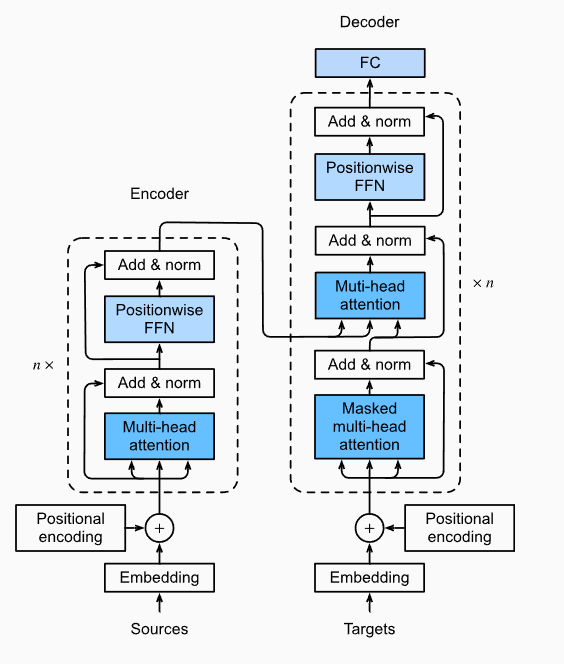

In [ ]:
import resources #functions helper file
import math
import pandas as pd
import torch
from torch import nn
import os
import requests
import torch

##Position-wise FFN implementation

We first impplement Position-wise FFn layers.  Those are composed of 2 linear layers, separated by a ReLu function.

In [ ]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        ### START CODE HERE ### 
        self.dense1 = nn.Linear( ??? , ??? )
        self.relu = ???
        self.dense2 = nn.Linear(???, ???)

    def forward(self, X):
        return ???

        ### END CODE HERE ###

In [ ]:
###Check cell
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

##Residual and LayerNorm layers implementation

We then implement the Residual connection + LayerNorm layer. Hint : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [ ]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        ### START CODE HERE ###
        self.ln = nn.LayerNorm(???)

    def forward(self, X, Y):
        return self.ln(???)
        ### END CODE HERE ###

In [ ]:
###Check cell
add_norm = AddNorm([3, 4], 0.5) # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

These cells below help to handle sequence masking for performing softmax at the end of the pipeline. You don't have to code anything here.

In [ ]:
def sequence_mask(X, valid_len, value=0):
  """Mask irrelevant entries in sequences."""
  maxlen = X.size(1)
  mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = value
  return X

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

The first step to implement self-attention module is to impelment a scaled-dot product attention function.

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, length of queries, `d`)
    # Shape of `keys`: (`batch_size`, length of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, length of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, length of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        ### START CODE HERE ###
        scores = ???
        self.attention_weights = masked_softmax(scores, valid_lens)
        return ???
        ### END OF CODE HERE ###

We can then impelment a MultiHead Attention module.

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
      

    def forward(self, queries, keys, values, valid_lens):
      # Shape of `queries`, `keys`, or `values`:
      # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
      # Shape of `valid_lens`:
      # (`batch_size`,) or (`batch_size`, no. of queries)
      # After transposing, shape of output `queries`, `keys`, or `values`:
      # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
      # `num_hiddens` / `num_heads`)

      ### START CODE HERE ###

      queries = resources.transpose_qkv(self.W_q(???), self.num_heads)
      keys = resources.transpose_qkv(self.W_k(???), self.num_heads)
      values = resources.transpose_qkv(self.W_v(???), self.num_heads)

      if valid_lens is not None:
          # On axis 0, copy the first item (scalar or vector) for
          # `num_heads` times, then copy the next item, and so on
          valid_lens = torch.repeat_interleave(
              valid_lens, repeats=self.num_heads, dim=0)

      # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
      # `num_hiddens` / `num_heads`)
      
      output = ???
      ### END CODE HERE ####

      # Shape of `output_concat`:
      # (`batch_size`, no. of queries, `num_hiddens`)
      output_concat = self.transpose_output(output, self.num_heads)
      return self.W_o(output_concat)

Now, we have all layers in our possession to impelment an Encoder and a Decoder block.

In [ ]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        ### START CODE HERE ####
        Y = self.addnorm1(???, ???)
        return self.addnorm2(???, ???)
        ### END OF CODE HERE ###

In [ ]:
### check cell ###
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

To finish the Encoder part, one just needs to add a Positional Encoding layer to handle input data.

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(
                10000,
                torch.arange(0, num_hiddens, 2, dtype=torch.float32) /
                num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

One can now build the Transformer Encoder block.

In [ ]:
class TransformerEncoder(nn.Module):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        ### START CODE HERE ###
        self.embedding = nn.Embedding(???, ???)
        self.pos_encoding = PositionalEncoding( ??? , ???)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = ???
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = ???
            self.attention_weights[i] = blk.attention.attention.attention_weights
        ### END CODE HERE ###
        return X

In [ ]:
###check cell
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

Now let's implement decoder block and Decoder Transformer part !

In [ ]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        ### START CODE HERE ###

        # Self-attention
        X2 = self.attention1(???, ??? , ??? , ??? )
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(???, ???, ???, ???)
        Z = self.addnorm2(Y, Y2)
        
        ### END CODE HERE ###

        return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):

        ### START CODE HERE ###

        X = ???

        ### END CODE HERE ###

        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

Now we can run training function:

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, torch.device('cuda')
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = resources.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
resources.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) #classical training procedure, uses teacher forcing

We can print some sentences of the dataset before evaluating our model with BLEU metrics.

In [ ]:
raw_text = resources.read_data_nmt()
print(raw_text[:2000])

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .', 'i fell .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .', 'je suis tombé .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = resources.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {resources.bleu(translation, fra, k=2):.3f}')

one can then print heatmaps of attention weights for respectively : encoder, decoder, and encoder-decoder attentions for different layers (here 2). 

In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
resources.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [ ]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape
resources.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [ ]:
resources.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))